In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
from PIL import Image
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import torch.nn.functional as F
import numpy as np
from google.colab import drive

seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# !unzip /content/drive/MyDrive/art_dataset.zip -d /content/drive/MyDrive/cs342fp/fixed_data/

In [4]:
%cd /content/drive/MyDrive/cs342fp/fixed_data/
# %cd kaggle/working/Art_Nouveau_Modern

/content/drive/MyDrive/cs342fp/fixed_data


In [5]:
import os

def count_files_in_folders(parent_folder):
    # Check if the parent folder exists
    if not os.path.exists(parent_folder):
        print(f"Parent folder '{parent_folder}' does not exist.")
        return

    # Iterate over all the directories in the parent folder
    for folder_name in os.listdir(parent_folder):
        folder_path = os.path.join(parent_folder, folder_name)

        # Check if it's a directory
        if os.path.isdir(folder_path):
            # Get the list of files in the directory
            files_in_folder = os.listdir(folder_path)
            num_files = len(files_in_folder)
            print(f"Folder '{folder_name}' contains {num_files} file(s).")

# Example usage:
parent_folder = 'kaggle/working/'
count_files_in_folders(parent_folder)


Folder 'Baroque' contains 1157 file(s).
Folder 'Color_Field_Painting' contains 1159 file(s).
Folder 'Early_Renaissance' contains 1159 file(s).
Folder 'Expressionism' contains 1159 file(s).
Folder 'Impressionism' contains 1132 file(s).
Folder 'Mannerism_Late_Renaissance' contains 1159 file(s).
Folder 'Naive_Art_Primitivism' contains 1141 file(s).
Folder 'Romanticism' contains 1147 file(s).
Folder 'Realism' contains 1157 file(s).
Folder 'Cubism' contains 1139 file(s).
Folder 'Minimalism' contains 1159 file(s).
Folder 'Art_Nouveau_Modern' contains 1149 file(s).
Folder 'Rococo' contains 1159 file(s).
Folder 'High_Renaissance' contains 1159 file(s).
Folder 'Northern_Renaissance' contains 1159 file(s).
Folder 'Ukiyo_e' contains 1159 file(s).


In [6]:
%pwd

'/content/drive/MyDrive/cs342fp/fixed_data'

In [7]:
import os
import random
import pandas as pd

# the 67% was cubism, high renaissance, color_field_painting

valid_genres = [
    # "Art_Nouveau_Modern",
    "Cubism", # abstract but with shapes
    # "Expressionism",
    "Mannerism_Late_Renaissance", # human figures
    # "Impressionism",
    "Color_Field_Painting", # plain abstract
    # 'Realism'
    "Ukiyo_e" # landscape
]

# Function to sample files from each child directory
def sample_files(parent_dir, num_samples):
    data = []
    # Iterate through each folder in the parent directory
    for folder in os.listdir(parent_dir):

        if folder not in valid_genres:
          continue

        folder_path = os.path.join(parent_dir, folder)
        if not os.path.isdir(folder_path):
          continue

        files_in_folder = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        # If there are fewer than num_samples files, sample all of them
        sampled_files = random.sample(files_in_folder, min(num_samples, len(files_in_folder)))

        # Get the genre (name of the child folder)
        genre = folder

        # Append the filename and genre to the data list
        for filename in sampled_files:
            data.append({'filename': os.path.join(genre, filename), 'genre': genre})

    return data

# Set the parent directory
parent_directory = "/content/drive/MyDrive/cs342fp/fixed_data/kaggle/working/"

# Sample files and create a dataframe
sampled_data = sample_files(parent_directory, num_samples=1100)

In [8]:
df = pd.DataFrame(sampled_data)

# Shuffle the rows of the dataframe
df = df.sample(frac=1).reset_index(drop=True)

# Create a column called "subset" and randomly set values
df['subset'] = 'train'  # Set default value to 'train'
test_indices = random.sample(range(len(df)), int(0.2 * len(df)))  # Select 20% of rows for testing
df.loc[test_indices, 'subset'] = 'test'  # Set subset value to 'test' for selected rows

df['genre'] = df['genre'].apply(lambda x: valid_genres.index(x))
df.reset_index(drop=True, inplace=True)

# Display the dataframe
print(df)
# Display the dataframe
print(df['subset'].value_counts())

                                               filename  genre subset
0     Color_Field_Painting/mark-rothko_untitled-blue...      2  train
1     Ukiyo_e/katsushika-hokusai_peasants-in-autumn.jpg      3  train
2               Ukiyo_e/ito-jakuchu_rousho-hakkeizu.jpg      3  train
3     Color_Field_Painting/morris-louis_number-32-19...      2  train
4     Mannerism_Late_Renaissance/tintoretto_portrait...      1  train
...                                                 ...    ...    ...
4395                Ukiyo_e/hiroshige_four-swallows.jpg      3  train
4396  Color_Field_Painting/barnett-newman_eleventh-s...      2  train
4397     Cubism/pablo-picasso_glass-and-fruits-1908.jpg      0  train
4398  Ukiyo_e/utagawa-kunisada_kagamiiwa-hamanosuke-...      3   test
4399  Color_Field_Painting/gene-davis_split-beat-196...      2  train

[4400 rows x 3 columns]
subset
train    3520
test      880
Name: count, dtype: int64


In [9]:
print(df.head())

                                            filename  genre subset
0  Color_Field_Painting/mark-rothko_untitled-blue...      2  train
1  Ukiyo_e/katsushika-hokusai_peasants-in-autumn.jpg      3  train
2            Ukiyo_e/ito-jakuchu_rousho-hakkeizu.jpg      3  train
3  Color_Field_Painting/morris-louis_number-32-19...      2  train
4  Mannerism_Late_Renaissance/tintoretto_portrait...      1  train


In [10]:
parent_dir = "kaggle/working/"

In [11]:
img_max = 512

In [12]:
class SimpleGatedAttention(nn.Module):
    def __init__(self, channel_size):
        super(SimpleGatedAttention, self).__init__()
        self.attention_weights = nn.Sequential(
            nn.Conv2d(channel_size * 2, channel_size, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x1, x2):
        g = self.attention_weights(torch.cat((x1, x2), dim=1))
        return x1 * g + x2 * (1 - g)

class CNNArtModel(nn.Module):
    def __init__(self, num_classes=16):
        super(CNNArtModel, self).__init__()
        # Path 1 for color usage
        self.path1_conv1 = nn.Conv2d(3, 16, kernel_size=6, padding=1)
        self.path1_pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.path1_conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.path1_pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.path1_conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.path1_pool3 = nn.AvgPool2d(kernel_size=2, stride=2)

        # Path 2 for textural qualities
        self.path2_conv1 = nn.Conv2d(3, 16, kernel_size=6, padding=1)
        self.path2_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.path2_conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.path2_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.path2_conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.path2_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Gated attention to merge paths
        self.gated_attention = SimpleGatedAttention(64)

        # Global average pooling and final classifier
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(64, num_classes)

    def forward(self, x):
        # Path 1
        x1 = F.relu(self.path1_conv1(x))
        x1 = self.path1_pool1(x1)
        x1 = F.relu(self.path1_conv2(x1))
        x1 = self.path1_pool2(x1)
        x1 = F.relu(self.path1_conv3(x1))
        x1 = self.path1_pool3(x1)

        # Path 2
        x2 = F.relu(self.path2_conv1(x))
        x2 = self.path2_pool1(x2)
        x2 = F.relu(self.path2_conv2(x2))
        x2 = self.path2_pool2(x2)
        x2 = F.relu(self.path2_conv3(x2))
        x2 = self.path2_pool3(x2)

        # Merge paths with gated attention
        x = self.gated_attention(x1, x2)

        # Global average pooling and classification
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Instantiate the model
print(CNNArtModel(16))


CNNArtModel(
  (path1_conv1): Conv2d(3, 16, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (path1_pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (path1_conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (path1_pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (path1_conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (path1_pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (path2_conv1): Conv2d(3, 16, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (path2_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (path2_conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (path2_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (path2_conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (path2_pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gated_attention): Simpl

In [13]:
# Split the dataframe into train and test subsets
train_df = df[df['subset'] == 'train']
test_df = df[df['subset'] == 'test']

import matplotlib.pyplot as plt

class SquarePad:
    def __call__(self, image):

        padded_tensor = torch.tensor(np.array(image), dtype=torch.float).permute(2,0,1)
        count = 0

        while padded_tensor.shape != (3,img_max,img_max):
          h = padded_tensor.shape[1]
          w = padded_tensor.shape[2]

          max_wh = max([w, h])
          hp = int((max_wh - w) // 2)
          vp = int((max_wh - h) // 2)
          padding = (hp, hp, vp, vp)
          if hp * 2 + w < img_max:
              padding = (hp, hp + 1, vp, vp)
          if vp * 2 + h < img_max:
              padding = (hp, hp, vp, vp + 1)

          padding = (min(padding[0], w-1),min(padding[1], w-1),min(padding[2], h-1),min(padding[3], h-1))

          padded_tensor = F.pad(padded_tensor,padding, mode='reflect')

        #Display the image after each padding iteration
        # image_np = padded_tensor.permute(1, 2, 0).numpy()
        # # Display the image
        # plt.imshow(image_np/255)
        # plt.show()

        assert(padded_tensor.shape == (3,img_max,img_max))
        return padded_tensor


def custom_normalize(image_tensor):
    # Normalize image tensor to the range [0, 1]
    normalized_image = image_tensor / 255.0
    return normalized_image

def resize_larger_dimension(image, size):
    width, height = image.size
    aspect_ratio = width / height
    if width > height:
        new_width = size
        new_height = int(size / aspect_ratio)
    else:
        new_width = int(size * aspect_ratio)
        new_height = size

    return image.resize((new_width, new_height))

transform = transforms.Compose([
    transforms.Lambda(lambda x: resize_larger_dimension(x, img_max)),  # Resize the larger dimension to img_max while preserving aspect ratio
    SquarePad(),
    # transforms.Lambda(lambda x: custom_normalize(x))
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

# Define a custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        filename = os.path.join(parent_dir, self.dataframe.iloc[idx]['filename'])
        # print(filename)
        image = Image.open(filename).convert('RGB')
        # print("got image")
        label = self.dataframe.iloc[idx]['genre']

        if self.transform:
            w, h = image.size
            image = self.transform(image)

        return image, label

# Create custom datasets for train and test
train_dataset = CustomDataset(train_df, transform=transform)
test_dataset = CustomDataset(test_df, transform=transform)

# Create train and test dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = CNNArtModel(num_classes=16).to(device)


# Modify the train_one_epoch function to move inputs and labels to GPU
def train_one_epoch(model, train_loader, test_loader, optimizer, criterion):
    total_loss = 0
    count = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        count += 1
        print(f'Train loss after iteration {count}: {total_loss/count}')
    print('{:>12s} {:>7.5f}'.format('Train loss:', total_loss/count))

    correct = 0
    total = 0
    true, pred = [], []
    with torch.no_grad():
        for inputs, labels  in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model.forward(inputs)
            predicted = torch.argmax(outputs, dim=1) # get predicted class label for each test example.
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true.append(labels)
            pred.append(predicted)
    acc = (100 * correct / total)
    print('accuracy: %0.3f' % (acc))
    print()
    return acc

# Example of using the train_loader and val_loader in a training loop
nepoch = 5
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

for epoch in range(nepoch):
    acc = train_one_epoch(model, train_loader, test_loader, optimizer, criterion)
    scheduler.step()
    torch.save(model, f'art_model_4classes_mlr_1100samps_lr0005_{epoch}_{round(acc,1)}.pt')

cuda
Train loss after iteration 1: 26.90967559814453
Train loss after iteration 2: 21.4266996383667
Train loss after iteration 3: 17.161441485087078
Train loss after iteration 4: 14.523662567138672
Train loss after iteration 5: 13.117760944366456
Train loss after iteration 6: 12.17484974861145
Train loss after iteration 7: 11.277342319488525
Train loss after iteration 8: 10.329694300889969
Train loss after iteration 9: 9.534801324208578
Train loss after iteration 10: 9.03289155960083
Train loss after iteration 11: 8.614349842071533
Train loss after iteration 12: 8.182529052098593
Train loss after iteration 13: 7.785392229373638
Train loss after iteration 14: 7.396613802228655
Train loss after iteration 15: 7.0425713380177815
Train loss after iteration 16: 6.7952751368284225
Train loss after iteration 17: 6.503076518283171
Train loss after iteration 18: 6.2285272346602545
Train loss after iteration 19: 6.000385685970909
Train loss after iteration 20: 5.785896116495133
Train loss after i

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

model.to('cpu')
model.eval()

# 3. Run inference and collect predictions and true labels
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.numpy())
        true_labels.extend(labels.numpy())


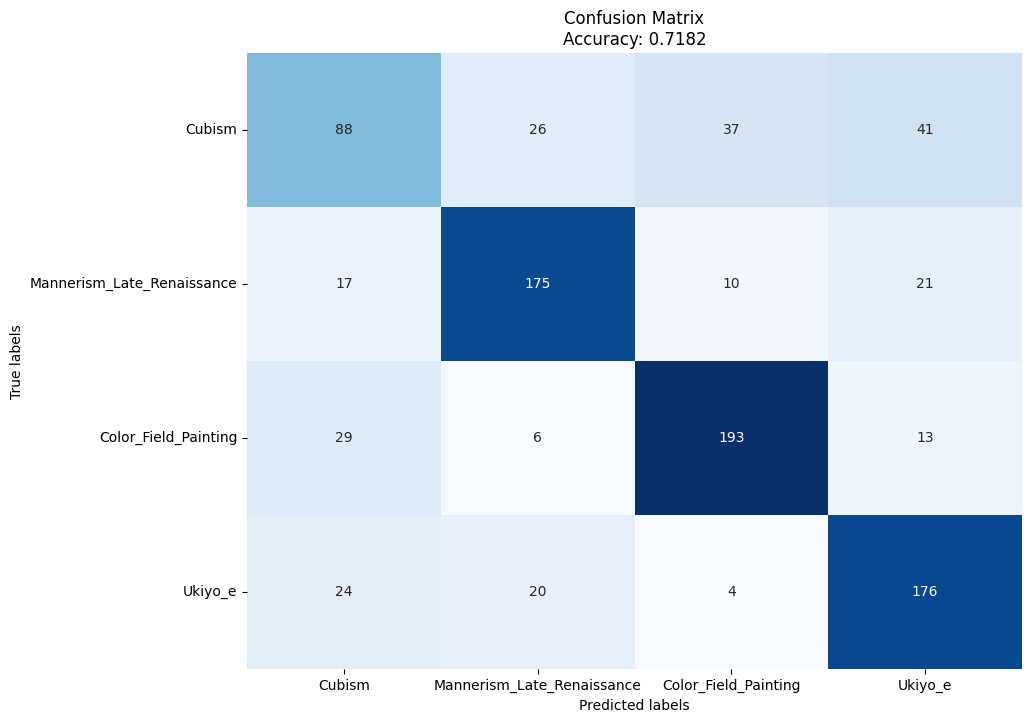

Accuracy: 0.7182


In [28]:
# Assuming valid_genres contains the list of genre strings
valid_genres = np.array(valid_genres)

# Compute the confusion matrix
conf_matrix = confusion_matrix(valid_genres[true_labels], valid_genres[predictions], labels=valid_genres)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=valid_genres, yticklabels=valid_genres)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.4f}')
plt.show()

# Print accuracy
print(f'Accuracy: {accuracy:.4f}')

In [29]:
print(np.unique(predictions))
print(np.unique(true_labels))
print(valid_genres)

[0 1 2 3]
[0 1 2 3]
['Cubism' 'Mannerism_Late_Renaissance' 'Color_Field_Painting' 'Ukiyo_e']
